# YOLOv2.1 inference using the TensorFlow

This notebook shows how to load and run a trained YOLOv2.1 model using TensoFlow.

Authors(s): *Martin Fränzl*

In [1]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter

import tensorflow as tf

import sys
sys.path.append('..') 
import configparser

import utils
import image_generator as ig

from tqdm import tqdm # progress bar

# Required for GPU support on Linux
config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0" # Change to "1" to use 2nd GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)

In [4]:
model_path = 'Dataset/TinyYOLOv21_416x416_Janus'

## Import trained model

### Load protocol buffer file (model weights)

In [5]:
gf = tf.gfile.FastGFile(model_path + '.pb', 'rb')
graph_def = tf.GraphDef()
graph_def.ParseFromString(gf.read()) # Parses a serialized binary message into the current message.
gf.close()

### Load INI file (parameters)

In [6]:
config = configparser.ConfigParser()
config.read(model_path + '.ini')

section = config.sections()[0] # General
IMAGE_H = int(config[section]['IMAGE_H'])
IMAGE_W = int(config[section]['IMAGE_W'])
LABELS  = config[section]['LABELS'].split(',')
CLASSES = len(LABELS)
ANCHORS = [float(a) for a in config[section]['ANCHORS'].split(',')]
INPUT_NODE_NAME  = config[section]['INPUT_NODE_NAME']
OUTPUT_NODE_NAME = config[section]['OUTPUT_NODE_NAME']

### Create session and import graph

In [7]:
session.graph.as_default()
tf.import_graph_def(graph_def) # Import a serialized TensorFlow grah_def protocol buffer and place into the current default `Graph`.

In [8]:
output_tensor = session.graph.get_tensor_by_name('import/' + OUTPUT_NODE_NAME + ':0')

## Test model on synthetic image

In [18]:
label_list = ['Janus']
parameters_list = [[[1], [9], [3]]] 

objects = ig.getRandom(1, 5, image_w=IMAGE_W, image_h=IMAGE_H, distance=15, offset=15, label_list=label_list, parameters_list=parameters_list)

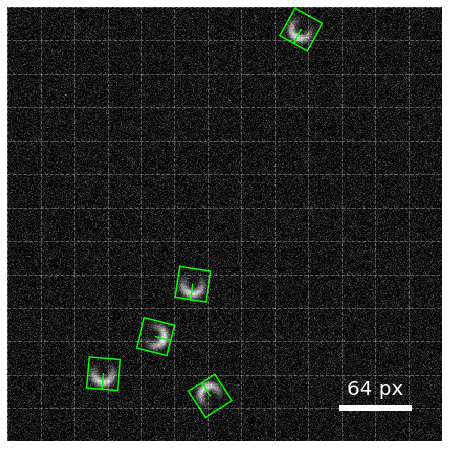

In [19]:
snr_range = 20
OBJ_THRESHOLD = 0.6
IOU_THRESHOLD = 0.45
color_list = ['lime']

i = 0
bboxes_truth, _, image = ig.generateImage(objects[i], IMAGE_W, IMAGE_H, snr_range, i_range=[0.1,1])  # a_range=[0.1,1]
input_tensor = np.expand_dims(np.stack((image, image, image)/image.max(), axis=-1), 0) # reshape image to input tensor shape
output = session.run(output_tensor, {'import/' + INPUT_NODE_NAME + ':0': input_tensor}) # run model
bboxes_model = utils.decode_netout(output[0], ANCHORS, CLASSES, OBJ_THRESHOLD, IOU_THRESHOLD) # decode output tensor

fig, ax = plt.subplots(1, 1, figsize=(8,8))

image = input_tensor[0,:,:,0]*255
utils.draw_boxes(image, ax, bboxes_model, color_list)

ax.set_xlim(0, IMAGE_W)
ax.set_ylim(IMAGE_H, 0)

ax.set_xticks(np.arange(0, IMAGE_W+1, step=32))
ax.set_yticks(np.arange(0, IMAGE_H+1, step=32))
ax.grid(lw=1, color='w', ls='--', alpha=0.3)  

ax.imshow(image, cmap='gray')

# scale bar
sb_x, sb_y = 352, 384
sb_px = 64
ax.text(sb_x, sb_y/1.05, str(sb_px) + ' px', va='center',ha='center', color='w', fontsize=20)
ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [sb_y, sb_y], 'w', lw=6);

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.tick_params(tick1On=False, tick2On=False)